In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
YEAR = 2023

In [39]:
def read_file(year):
    PATH = f'../dataset/imbank_customer_data/iMBANK_CUSTOMER_DATA_{year}(K-DigitalTraining).csv'
    df = pd.read_csv(PATH, encoding='euc-kr', usecols=['기준년월', '고객ID', '연령대'])
    df = df.sort_values(by='기준년월', ascending=True).reset_index(drop=True)
    return df

CS = read_file(YEAR)

In [40]:
def read_file1(year):
    PATH = f'../dataset/imbank_card_data/iMBANK_CARD_DATA_{year}(K-DigitalTraining).csv'
    df = pd.read_csv(PATH, encoding='euc-kr', usecols=['거래년월', '고객ID'])
    df = df.sort_values(by='거래년월', ascending=True).reset_index(drop=True)
    return df
C = read_file1(YEAR)

In [41]:
# 거래년월이 202212 이전인 데이터 필터링 -> 12월 안가져가도 되나???? 
filtered_data = C[C['거래년월'] < int(f"{YEAR}12")]

# 마지막 거래년월 찾기
last_transaction = filtered_data.groupby('고객ID')['거래년월'].max().reset_index()
last_transaction.columns = ['고객ID', '마지막 거래년월']
last_transaction.tail()

,고객ID,마지막 거래년월
728007,9999887084,202311
728008,9999891415,202308
728009,9999911884,202304
728010,9999918728,202310
728011,9999998161,202311


In [64]:
# 고객ID 기준 Data_frame merge
merge_card = pd.merge(C, last_transaction, on='고객ID', how='left')
merge_card.tail(15)

,거래년월,고객ID,마지막 거래년월
64829362,202312,6728335990,202311.0
64829363,202312,7859015073,202311.0
64829364,202312,7855695312,202311.0
64829365,202312,7864478616,202311.0
64829366,202312,7421820821,202311.0
64829367,202312,7339178814,202311.0
64829368,202312,7180433084,202311.0
64829369,202312,5384613414,202311.0
64829370,202312,9675456591,202311.0
64829371,202312,4406597530,202311.0


In [65]:
merge_card.shape

(64829377, 3)

In [66]:
# 거래이후 소요시간 계산 
current_year_month = int(f'{YEAR}11')
merge_card['거래이후소요기간'] = ((current_year_month // 100 - merge_card['마지막 거래년월'] // 100) * 12 +
                                        (current_year_month % 100 - merge_card['마지막 거래년월'] % 100))

In [67]:
# 거래년월 컬럼 삭제 
new_card = merge_card.drop(columns=['거래년월'])

In [68]:
#마지막컬럼 남기고 중복 제거 -> 거래이후소요기간은 동일 값이라 정렬 필요 없음
new_card = new_card.drop_duplicates(subset='고객ID', keep='last').reset_index(drop=True)
new_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736496 entries, 0 to 736495
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   고객ID      736496 non-null  int64  
 1   마지막 거래년월  728012 non-null  float64
 2   거래이후소요기간  728012 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 16.9 MB


In [69]:
new_card.shape

(736496, 3)

In [70]:
# 이탈 여부 판단
new_card['이탈여부'] = np.where(new_card['거래이후소요기간'] > 1,'이탈', '유지')

In [71]:
new_card.groupby(['이탈여부']).count()

,고객ID,마지막 거래년월,거래이후소요기간
이탈여부,,,
유지,585716,577232,577232
이탈,150780,150780,150780


In [48]:
# CS 데이터 기준년월컬럼 삭제 및 고객ID 중복 거거
CS = CS.drop(columns='기준년월')

In [ ]:
# card_2023 & CS_2023 merge
last = new_card.merge(CS, on=['고객ID'], how='left')

# 고객 ID 중복 제거
last = last.drop_duplicates(subset='고객ID', keep='last').reset_index(drop=True)
last.head()

,고객ID,마지막 거래년월,거래이후소요기간,이탈여부,연령대
0,9902238082,202301.0,10.0,이탈,60대이상
1,3591992975,202301.0,10.0,이탈,40대
2,3730210895,202301.0,10.0,이탈,20대
3,8896478537,202301.0,10.0,이탈,30대
4,8063560249,202301.0,10.0,이탈,30대


In [72]:
last.shape

(736496, 5)

In [50]:
# 서머리 결과 DF 형태로 저장
summary = pd.DataFrame(last.groupby(['이탈여부','연령대'])['고객ID'].count())
summary = summary.reset_index()

In [61]:
# 유지와 이탈 고객의 전체 수
total유지 = summary[summary['이탈여부'] == '유지']['고객ID'].sum()
total이탈 = summary[summary['이탈여부'] == '이탈']['고객ID'].sum()

# 비율 계산
summary['비율'] = summary.apply(lambda row: row['고객ID'] / total유지 if row['이탈여부'] == '유지' else
                      (row['고객ID'] / total이탈 if row['이탈여부'] == '이탈' else 0), axis=1)

# 결과 출력
summary

,이탈여부,연령대,고객ID,비율
0,유지,10대미만,23421,0.040661
1,유지,20대,75939,0.131838
2,유지,30대,72665,0.126154
3,유지,40대,101435,0.176101
4,유지,50대,136092,0.236269
5,유지,60대이상,166452,0.288977
6,이탈,10대미만,6295,0.042162
7,이탈,20대,27216,0.182283
8,이탈,30대,23333,0.156276
9,이탈,40대,28467,0.190662


In [52]:
# 중복 확인
dupl = summary['고객ID'].duplicated().any()
if dupl:
    print('중복')
else:
    print('중복아님')

중복아님


In [53]:
# 시각화 그리기 한글폰트 가가
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')

In [84]:
last

,고객ID,마지막 거래년월,거래이후소요기간,이탈여부,연령대
0,9902238082,202301.0,10.0,이탈,60대이상
1,3591992975,202301.0,10.0,이탈,40대
2,3730210895,202301.0,10.0,이탈,20대
3,8896478537,202301.0,10.0,이탈,30대
4,8063560249,202301.0,10.0,이탈,30대
...,...,...,...,...,...
736491,5996611034,202311.0,0.0,유지,50대
736492,5791291255,202311.0,0.0,유지,60대이상
736493,3557388137,202311.0,0.0,유지,20대
736494,9675608397,202311.0,0.0,유지,60대이상


In [93]:
label = last['연령대'].value_counts().sort_index()
label = label.reset_index()

In [95]:
churn = last[['이탈여부', '연령대']].value_counts()
churn = churn.reset_index()

In [96]:
churn

,이탈여부,연령대,count
0,유지,60대이상,166452
1,유지,50대,136092
2,유지,40대,101435
3,유지,20대,75939
4,유지,30대,72665
5,이탈,60대이상,33673
6,이탈,50대,30322
7,이탈,40대,28467
8,이탈,20대,27216
9,유지,10대미만,23421


In [98]:
data = pd.merge(label, churn, on = '연령대')

In [ ]:
# 이탈여부로 분리


,연령대,count_x,이탈여부,count_y
0,10대미만,29716,유지,23421
1,10대미만,29716,이탈,6295
2,20대,103155,유지,75939
3,20대,103155,이탈,27216
4,30대,95998,유지,72665
5,30대,95998,이탈,23333
6,40대,129902,유지,101435
7,40대,129902,이탈,28467
8,50대,166414,유지,136092
9,50대,166414,이탈,30322


TypeError: unhashable type: 'numpy.ndarray'

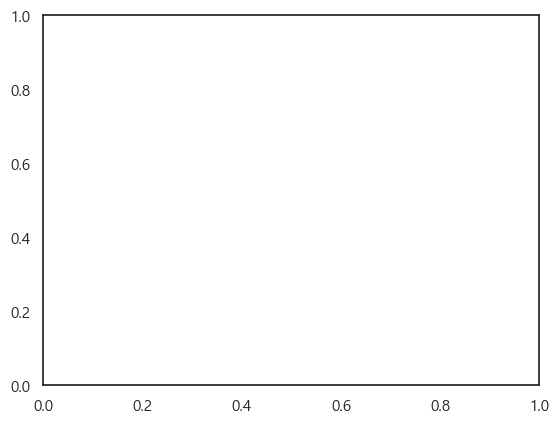

In [ ]:
# fig, ax = plt.subplots()
# ax.bar(data, height=data['count_x'])
# plt.show()

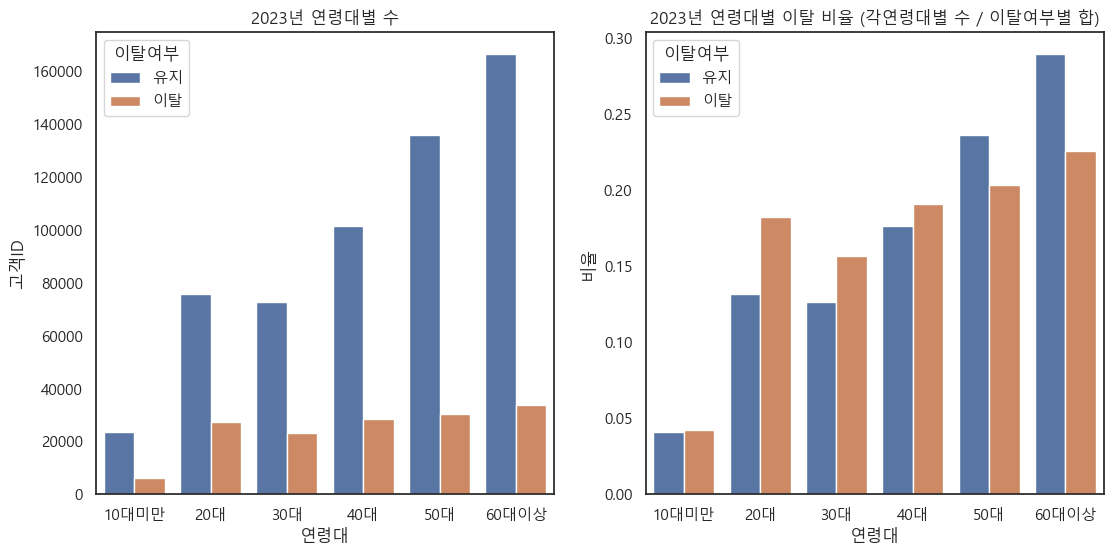

In [82]:
fig, ax = plt.subplots(figsize = (13,6), ncols=2)
sns.barplot(summary, x='연령대', y = '고객ID', hue='이탈여부', ax=ax[0])
sns.barplot(summary, x='연령대', y = '비율', hue='이탈여부', ax=ax[1])

ax[0].set_title(f'{YEAR}년 연령대별 수', )
ax[1].set_title(f'{YEAR}년 연령대별 이탈 비율 (각연령대별 수 / 이탈여부별 합)')
plt.show()

In [56]:
last.to_csv(f'../dataset/summary_{YEAR}.csv', index=False, encoding="utf-8-sig")